# Preprocessing

In [2]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import plotly.express as px
from configuration.config import DATA_PATH

MODELING_PATH = os.path.join(DATA_PATH, 'modeling/train-test/')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, RobustScaler

In [5]:
df = pd.read_csv(DATA_PATH +'preprocessing/data_new_features.csv')

In [6]:
pd.set_option('display.max_columns', None)
df.head()

,BHCMISID,HealthCenterName,HealthCenterState,FundingCHC,FundingMHC,FundingHO,FundingPH,UrbanRuralFlag,total_hc_funding,total_other_revenue,total_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,other_revenue_category,diverse_race_proportion,hispanic_proportion,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,ZipCode_Count_bins,total_other_revenue_bins,total_patients_bins,diverse_race_proportion_bins,hispanic_proportion_bins,low_income_ratio_bins,poverty_ratio_bins,medicaid_ratio_bins,lep_patients_ratio_bins,private_insurance_ratio_bins,uninsured_ratio_bins,medicare_18_up_ratio_bins,homeless_patients_ratio_above_median,veteran_patients_ratio_above_median,public_housing_patients_ratio_above_median,migrant_patients_ratio_above_median,school_based_patients_ratio_above_median,public_insurance_ratio_above_median,total_enabling_visits,total_visits,total_sites,ops_confidential,fin_confidential
0,010030,"HOLYOKE HEALTH CENTER, INC.",MA,True,False,False,False,Urban,5721128,14258919,19144,NaN,NaN,NaN,50,3,175.0,6112612,0.27036,1M to 30M,0.033692,0.659789,0.141350,0.269379,0.730621,0.437265,0.141350,0.156341,0.037244,0.706226,0.173422,0.001149,0.082323,Q2,Q4,Q3,Q1,Q4,Q1,Q1,Q4,Q4,Q1,Q1,Q4,1,1,1,0,0,1,NaN,NaN,4,True,True
1,010040,MAINE MOBILE HEALTH PROGRAM INC.,ME,False,True,False,False,Rural,1758567,36578,850,2183264.0,617158.0,263.0,24,2,195.0,525083,0.93488,Less than 100K,0.420000,0.554118,0.903529,0.075294,0.924706,0.769412,0.903529,0.992941,0.904706,0.070588,0.009412,0.000000,0.010588,Q1,Q2,Q1,Q4,Q4,Q4,Q4,Q1,Q4,Q1,Q4,Q1,1,1,0,1,0,0,629.0,2573.0,6,False,False
2,010060,"FAIR HAVEN COMMUNITY HEALTH CLINIC, INC.",CT,True,False,False,False,Urban,4569124,270649,31918,33153465.0,1716660.0,3539.0,62,3,603.0,4006086,0.89113,100K to 500K,0.247854,0.601667,0.411617,0.606805,0.393195,0.397456,0.411617,0.588414,0.139952,0.699073,0.052823,0.000000,0.108121,Q3,Q3,Q4,Q3,Q4,Q2,Q2,Q4,Q4,Q1,Q2,Q1,0,0,1,0,1,0,6151.0,124280.0,17,False,False
3,010070,CORNELL SCOTT HILL HEALTH CORPORATION,CT,True,False,True,True,Urban,6160674,1753132,52434,NaN,NaN,NaN,116,5,1206.0,9298309,0.82119,1M to 30M,0.356849,0.378762,0.432982,0.154976,0.845024,0.232616,0.432982,0.540889,0.103711,0.621658,0.061220,0.000000,0.213373,Q4,Q4,Q4,Q3,Q3,Q2,Q3,Q4,Q3,Q3,Q2,Q1,1,0,1,0,1,0,NaN,NaN,37,True,True
4,010120,"CITY OF SPRINGFIELD, MASSACHUSETTS",MA,False,False,True,False,Urban,1842241,0,2055,2684614.0,8876.0,1140.0,21,4,158.0,200000,0.95955,Zero,0.233577,0.417032,0.628224,0.017518,0.982482,0.224331,0.628224,0.672993,0.161071,0.660341,0.143552,0.000000,0.035036,Q1,NaN,Q1,Q3,Q3,Q3,Q4,Q4,Q3,Q1,Q2,Q3,1,1,0,1,0,0,3100.0,9538.0,10,False,False


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 56 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   BHCMISID                                    1342 non-null   object 
 1   HealthCenterName                            1342 non-null   object 
 2   HealthCenterState                           1342 non-null   object 
 3   FundingCHC                                  1342 non-null   bool   
 4   FundingMHC                                  1342 non-null   bool   
 5   FundingHO                                   1342 non-null   bool   
 6   FundingPH                                   1342 non-null   bool   
 7   UrbanRuralFlag                              1342 non-null   object 
 8   total_hc_funding                            1342 non-null   int64  
 9   total_other_revenue                         1342 non-null   int64  
 10  total_patien

# Overview of Preprocessing Strategy

My first step is to transform all data into numerical data that can be processed and analyzed by various ML models. 

### Steps to take for preprocessing

**1. Transform data so that it only contains numerical information**
* Drop the identifier columns `BHMISID` and `HealthCenterName` as they are not needed at this point in time.
* Encode the `HealthCenterState` using frequency encoding. I am choosing this method because the states may influence funding levels. More funding gets allocated to states with higher populations, so to preserve this importance, I am going to use a frequency encoding technique. Although this is a categorical column, it will get scaled with numerical data otherwise the size will affect models that depend on distance (like PCA).

**2. Split the data into train and test sets**

**2. Deal with missing values**

The dataset contains 5 columns with missing values, about 43% of the observations are missing. The columns are identified below. This data is not missing at random. Health centers have opted to keep this information confidential. In order to take a comprehensive approach to handling this for modeling, I created indicator columns to identify which observations opted to withhold these data. `ops_confidential` identifies entities that withheld oeprations data (visits and patient counts by visit type). `fin_confidential` identifies entities that withheld financial data (costs of care and sliding fee scale details).

For modeling, I will have two train/test splits:

* *Split 1:* Does not include the columns with missing values, but will include the missing indicator columns. 
* *Split 2:* Missing values will be imputed with `MICE` imputation and will also include the missing indicator columns. 

I will evaluate each of the train/test splits to see if models perform better with removed columns or imputed data.

**4. Scale the data**
First I need to identify the numerical columns that need to be scaled. The reduced and the imputed `X_train` and `X_test` data will be split into `X_train_num`, `X_train_cat`, `X_test_num`, and `X_test_cat`. 

In order to scale the data, I will need to consider strategies to deal with outliers. The outliers in the data are not due to errors. Some health centers have much larger operations, so it is expected to see skewed results for many features. Because these outliers may provide valuable insights, I will want to evaluate models that include them. However, these outliers may prove to be problematic and I may need to transform the data to reduce the impact of outliers. I will use two different scaling techniques and evaluate models on both:

* `RobustScaler()`: This scaler is less sensitive to outliers, and will scales data according to the median and the interquartile range. This will reduce the influence of extreme outliers in the data. 
* `PowerTransformer()`: This scaler applies transformations that reduce the impact of outliers. Log transformation, square root, or Box-Cox transformations can help reduce the variance and effect of extreme values.

Each scaler will be applied to each of the numerical train/test splits. The result will be 4 sets of train/test data to use for modeling. 

**5. Encode categorical data**

Next I need to encode the remaining categorical columns:
* Encode the Funding-Type columns (`FundingCHC`, `FundingMHC`, `FundingPH`, `FundingHO`) from boolean to integers.
* Dummy encode the `UrbanRuralFlag` and `other_revenue_category` columns

I will then concatenate the numerical dfs with their categorical counterparts.

**5. Save dataframes and proceed with modeling the data**



In [8]:
# drop identification columns
df = df.drop(columns=['BHCMISID', 'HealthCenterName'])

In [9]:
# Find columns that end with '_ratio' and '_above_median'
bins_columns = df.filter(regex='_bins$').columns
median_columns = df.filter(regex='_above_median$').columns

# Drop these columns
df = df.drop(bins_columns, axis=1)
df = df.drop(median_columns, axis=1)

In [10]:
# encode health center states by using frequency counts for each state
state_frequency = df['HealthCenterState'].value_counts()
df['state_freq_enc'] = df['HealthCenterState'].map(state_frequency)

# drop HealthCenterState column
df = df.drop(columns='HealthCenterState')

# Reduced DF

In [11]:
# drop columns with missing data
cols_to_drop = ['total_cost_care', 'total_sfs', 'enabling_patients', 'total_enabling_visits', 'total_visits']
df_r = df.drop(columns=cols_to_drop)

In [12]:
X = df_r.drop(columns='total_hc_funding')
y = df_r[['total_hc_funding']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=48)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(939, 30) (403, 30) (939, 1) (403, 1)


In [15]:
y_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,total_hc_funding
count,939.00
mean,3692968.61
std,2770426.72
min,350255.00
25%,1774271.00
50%,2888437.00
75%,4645597.50
max,20027136.00


In [16]:
y_test.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,total_hc_funding
count,403.00
mean,3616509.78
std,2676956.44
min,275778.00
25%,1924694.50
50%,2830113.00
75%,4473025.50
max,22382349.00


In [17]:
numerical_cols = X.select_dtypes(include=['int', 'float']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

In [18]:
X_train_cat = X_train[categorical_cols]
X_test_cat = X_test[categorical_cols]

In [19]:
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, dtype=int)
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, dtype=int)

In [20]:
def convert_bool_numeric(df, col_list):
    """
    Converts columns specified in col_list from boolean to integer type within the given DataFrame.
    
    This function iterates over a list of columns in a DataFrame that are currently of boolean type 
    and converts each of them to an integer type, where True becomes 1 and False becomes 0. 
    This is particularly useful for preparing data for machine learning models that require 
    numerical input features.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to convert.
    col_list (list of str): A list of column names in the DataFrame that are to be converted from boolean to integer.

    Returns:
    None: Modifies the DataFrame in-place; does not return anything.
    """
    for col in col_list:
        df[col] = df[col].astype('int')

In [21]:
# convert boolean columns to integers
convert_bool_numeric(X_train_cat, ['FundingCHC', 'FundingMHC', 'FundingHO', 'FundingPH', 'ops_confidential', 'fin_confidential'])
convert_bool_numeric(X_test_cat, ['FundingCHC', 'FundingMHC', 'FundingHO', 'FundingPH', 'ops_confidential', 'fin_confidential'])


## PowerTransform

In [22]:
power = PowerTransformer()

X_train_num_power = pd.DataFrame(power.fit_transform(X_train[numerical_cols]), columns=numerical_cols, index=X_train[numerical_cols].index)
X_test_num_power = pd.DataFrame(power.transform(X_test[numerical_cols]), columns=numerical_cols, index=X_test[numerical_cols].index)

In [23]:
X_train_reduced_power = pd.concat([X_train_num_power, X_train_cat], axis=1)
X_test_reduced_power = pd.concat([X_test_num_power, X_test_cat], axis=1)

In [24]:
X_train_reduced_power.head()

,total_other_revenue,total_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,total_sites,state_freq_enc,FundingCHC,FundingMHC,FundingHO,FundingPH,ops_confidential,fin_confidential,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_500K to 1M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero
1182,0.864453,-0.130085,-0.559185,-0.519894,-0.261967,0.118330,-0.625433,-1.067515,0.958253,-0.090896,0.656125,-0.660887,0.981222,-0.090896,0.035040,-0.487092,1.400293,-0.372449,0.347772,-0.985827,-0.204745,1.832614,1,0,1,0,0,0,1,0,1,0,0,0
588,0.532917,1.534575,0.502977,1.530817,1.426568,0.493355,0.406199,0.767288,-0.061108,0.497829,0.699746,-0.705011,-0.649102,0.497829,0.291129,0.265404,0.473293,-1.228708,-0.541739,0.192778,1.207500,-0.312331,1,0,0,0,0,0,1,0,0,0,0,0
459,-0.251105,0.095365,-0.034151,-0.001727,-0.204394,-0.758541,0.882699,-0.785584,-1.157500,-0.934746,1.219339,-1.228657,-1.127328,-0.934746,-1.044792,-0.952797,-0.227463,0.228276,-0.541739,1.324180,-0.411371,-0.411101,1,0,0,0,1,1,0,0,0,1,0,0
1197,-0.415453,0.371288,1.013616,0.829392,0.758532,1.091113,0.229139,-1.037650,1.627883,1.310671,0.221910,-0.221281,1.514459,1.310671,0.980762,0.494197,1.400438,-1.404740,-0.541739,-1.656848,0.808872,1.832614,1,0,0,0,1,1,1,0,0,1,0,0
1176,0.234827,-1.623744,-0.456403,-1.377103,-2.078088,-1.018247,-0.405482,0.778606,0.722237,-0.641818,-0.279069,0.284887,-0.214861,-0.641818,-0.322076,-1.766751,1.464051,0.319604,-0.541739,-0.549560,-2.066189,1.832614,1,0,0,0,0,0,1,0,0,0,0,0


## RobustScaler

In [25]:
robust = RobustScaler()

X_train_num_robust = pd.DataFrame(robust.fit_transform(X_train[numerical_cols]), columns=numerical_cols, index=X_train[numerical_cols].index)
X_test_num_robust = pd.DataFrame(robust.transform(X_test[numerical_cols]), columns=numerical_cols, index=X_test[numerical_cols].index)

In [26]:
X_train_reduced_robust = pd.concat([X_train_num_robust, X_train_cat], axis=1)
X_test_reduced_robust = pd.concat([X_test_num_robust, X_test_cat], axis=1)

In [27]:
X_train_reduced_robust.head()

,total_other_revenue,total_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,total_sites,state_freq_enc,FundingCHC,FundingMHC,FundingHO,FundingPH,ops_confidential,fin_confidential,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_500K to 1M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero
1182,1.416409,-0.071385,-0.349515,-0.25,-0.166460,0.104617,-0.455664,-0.351127,0.700901,-0.060385,0.491696,-0.491696,0.716570,-0.060385,0.014687,-0.243450,0.897578,-0.182302,2.416037,-0.585828,-0.1,4.711864,1,0,1,0,0,0,1,0,1,0,0,0
588,0.513145,2.516042,0.524272,2.25,1.965217,0.454502,0.155642,0.558292,0.013053,0.343456,0.527910,-0.527910,-0.222639,0.343456,0.172982,0.203369,0.312839,-0.611596,0.000000,0.156251,1.5,-0.271186,1,0,0,0,0,0,1,0,0,0,0,0
459,-0.187175,0.080958,0.000000,0.00,-0.137888,-0.342736,0.365512,-0.260862,-0.405707,-0.579490,0.978049,-0.978049,-0.373542,-0.579490,-0.726591,-0.454687,-0.136407,0.194868,0.000000,1.108374,-0.2,-0.338983,1,0,0,0,1,1,0,0,0,1,0,0
1197,-0.222785,0.321771,1.242718,0.75,0.680745,1.360050,0.068694,-0.342046,1.589654,0.963498,0.143672,-0.143672,1.469028,0.963498,0.574541,0.378100,0.897669,-0.688144,0.000000,-0.930297,0.8,4.711864,1,0,0,0,1,1,1,0,0,1,0,0
1176,0.091346,-0.527481,-0.291262,-0.50,-0.591304,-0.414242,-0.299439,0.567949,0.497174,-0.406851,-0.231458,0.231458,-0.055040,-0.406851,-0.215958,-0.749912,0.937429,0.259604,0.000000,-0.334179,-0.6,4.711864,1,0,0,0,0,0,1,0,0,0,0,0


## Handling missing values in train and test splits

Below I want to verify that the train and test splits have similar percentages of missing data. 

In [28]:
df_i = df

In [29]:
X = df_i.drop(columns='total_hc_funding')
y = df_i[['total_hc_funding']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=48)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(939, 35) (403, 35) (939, 1) (403, 1)


In [30]:
missing_proportion = X_train.isna().sum().reset_index()
missing_proportion.columns = ['column', 'missing']
missing_proportion.sort_values('missing', ascending=False)
missing_proportion['perc_missing'] = round(missing_proportion['missing'] / len(X_train) * 100, 2)
missing_df_test = missing_proportion[missing_proportion['perc_missing'] > 0]
missing_df_test


,column,missing,perc_missing
7,total_cost_care,422,44.94
8,total_sfs,422,44.94
9,enabling_patients,388,41.32
29,total_enabling_visits,388,41.32
30,total_visits,388,41.32


In [31]:
missing_proportion = X_test.isna().sum().reset_index()
missing_proportion.columns = ['column', 'missing']
missing_proportion.sort_values('missing', ascending=False)
missing_proportion['perc_missing'] = round(missing_proportion['missing'] / len(X_test) * 100, 2)
missing_df_test = missing_proportion[missing_proportion['perc_missing'] > 0]
missing_df_test


,column,missing,perc_missing
7,total_cost_care,188,46.65
8,total_sfs,190,47.15
9,enabling_patients,173,42.93
29,total_enabling_visits,173,42.93
30,total_visits,173,42.93


In [32]:
numerical_cols = X.select_dtypes(include=['int', 'float']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

### Imputing missing data and keeeping missingness indicator columns

In [33]:
from miceforest import ImputationKernel

mice_kernel = ImputationKernel(X_train[numerical_cols], 
                          save_all_iterations = True, 
                          random_state=48)

mice_kernel.mice(10)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

,total_other_revenue,total_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,total_enabling_visits,total_visits,total_sites,state_freq_enc
1182,856948,11600,20615400.0,694271.0,0.0,34,2,218.0,3478144,0.80232,0.034828,0.472500,0.387500,0.320259,0.679741,0.325776,0.387500,0.614310,0.113707,0.708103,0.083621,0.002759,0.091552,0.0,65097.0,6,174
588,396792,64302,52333632.0,3152267.0,1069.0,79,12,1076.0,5132526,0.92824,0.341762,0.197023,0.528848,0.325977,0.674023,0.054648,0.528848,0.675531,0.196837,0.541165,0.039532,0.000000,0.222419,2770.0,273867.0,22,27
459,40023,14703,13886649.0,165044.0,0.0,52,3,229.5,1362899,0.97147,0.065293,0.029314,0.205808,0.397062,0.602938,0.011086,0.205808,0.327620,0.074407,0.412909,0.122356,0.000000,0.390329,0.0,47702.0,5,25
1197,21882,19608,27891578.0,2602363.0,14112.0,116,6,559.0,9414279,0.91033,0.037893,0.828437,0.745869,0.265300,0.734700,0.542993,0.745869,0.830834,0.229345,0.708129,0.031671,0.000000,0.030804,40405.0,93677.0,15,174
1176,181912,2310,5050953.0,23812.0,0.0,37,1,47.0,1024791,0.83450,0.345022,0.390909,0.266234,0.206061,0.793939,0.103030,0.266234,0.525108,0.019481,0.719481,0.129004,0.000000,0.135931,0.0,7290.0,1,174


In [34]:
mice_kernel


              Class: ImputationKernel
           Datasets: 1
         Iterations: 10
       Data Samples: 939
       Data Columns: 27
  Imputed Variables: 5
save_all_iterations: True

The distributions for the imputed columns are similar to the original data's distributions. 

In [35]:
X_train_num_imputed = mice_kernel.complete_data(0)
X_test_num_imputed = mice_kernel.impute_new_data(new_data=X_test[numerical_cols]).complete_data(0)


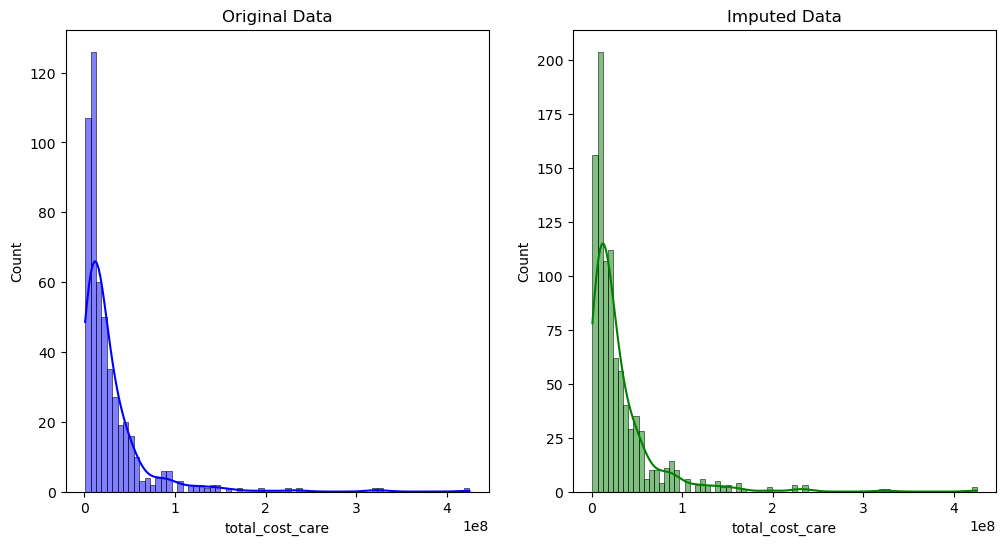

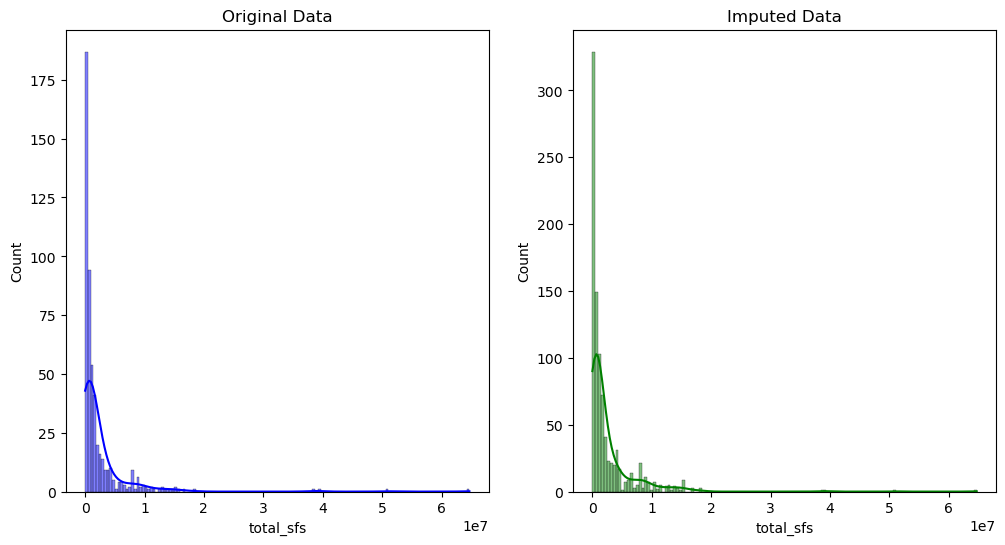

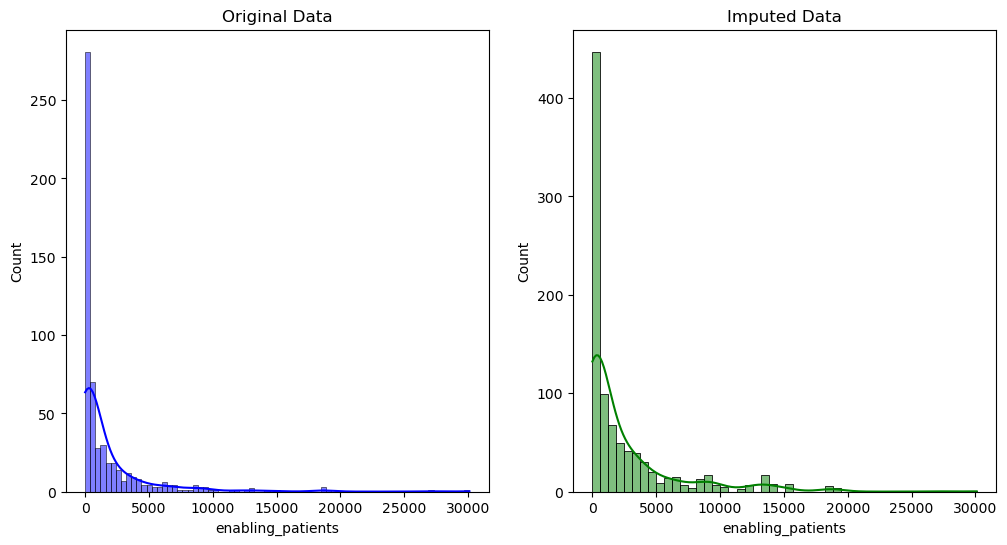

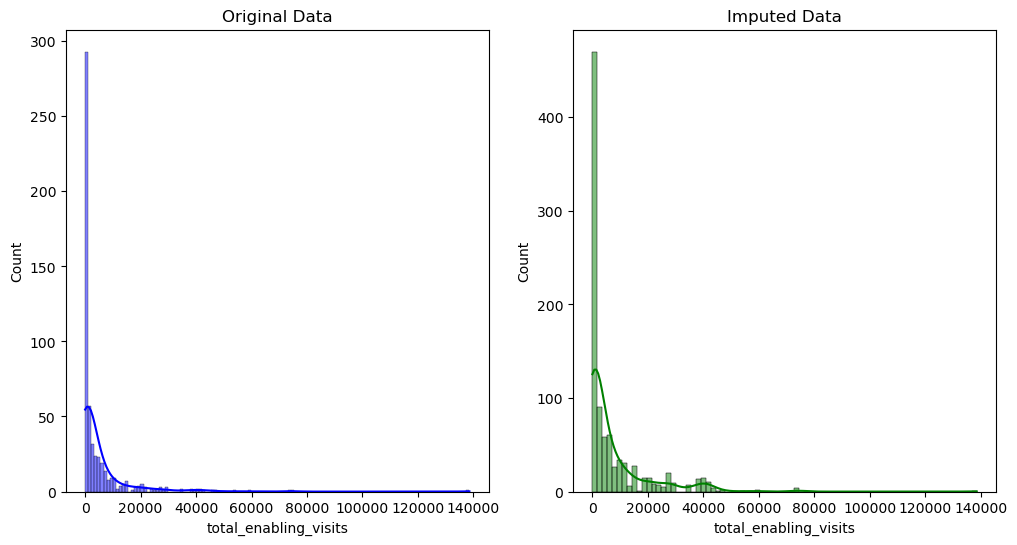

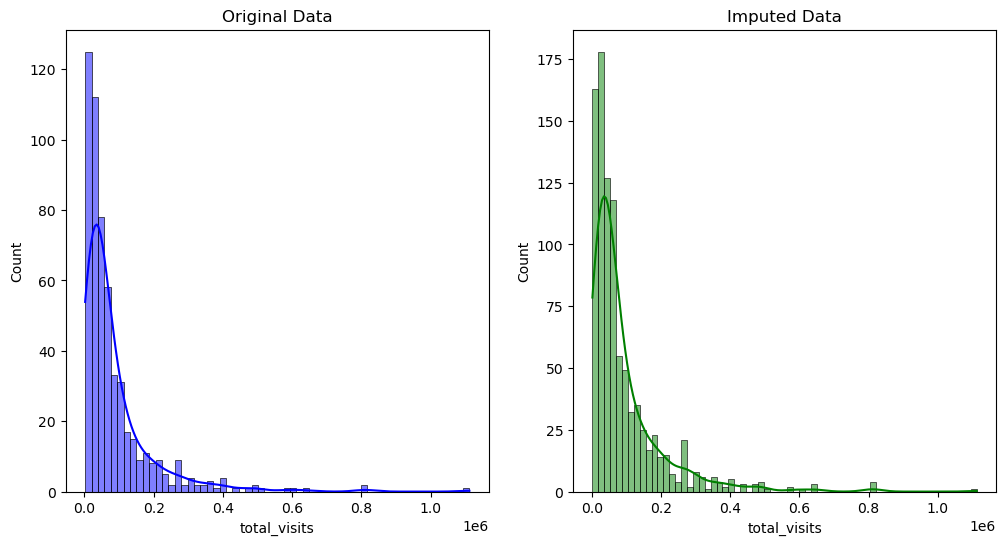

In [36]:
# Compare distributions of original and imputed data
for col in cols_to_drop:
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(X_train[col].dropna(), kde=True, ax=ax[0], color='blue')
    ax[0].set_title('Original Data')
    sns.histplot(X_train_num_imputed[col], kde=True, ax=ax[1], color='green')
    ax[1].set_title('Imputed Data')
    plt.show()


In [37]:
X_train_cat = X_train[categorical_cols]
X_test_cat = X_test[categorical_cols]
X_train_cat = pd.get_dummies(X_train_cat, drop_first=True, dtype=int)
X_test_cat = pd.get_dummies(X_test_cat, drop_first=True, dtype=int)

In [38]:
def convert_bool_numeric(df, col_list):
    """
    Converts columns specified in col_list from boolean to integer type within the given DataFrame.
    
    This function iterates over a list of columns in a DataFrame that are currently of boolean type 
    and converts each of them to an integer type, where True becomes 1 and False becomes 0. 
    This is particularly useful for preparing data for machine learning models that require 
    numerical input features.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns to convert.
    col_list (list of str): A list of column names in the DataFrame that are to be converted from boolean to integer.

    Returns:
    None: Modifies the DataFrame in-place; does not return anything.
    """
    for col in col_list:
        df[col] = df[col].astype('int')
# convert boolean columns to integers
convert_bool_numeric(X_train_cat, ['FundingCHC', 'FundingMHC', 'FundingHO', 'FundingPH', 'ops_confidential', 'fin_confidential'])
convert_bool_numeric(X_test_cat, ['FundingCHC', 'FundingMHC', 'FundingHO', 'FundingPH', 'ops_confidential', 'fin_confidential'])



In [39]:
## PowerTransform
power = PowerTransformer()

X_train_num_power = pd.DataFrame(power.fit_transform(X_train_num_imputed), columns=numerical_cols, index=X_train_num_imputed.index)
X_test_num_power = pd.DataFrame(power.transform(X_test_num_imputed), columns=numerical_cols, index=X_test_num_imputed.index)

In [40]:
X_train_imputed_power = pd.concat([X_train_num_power, X_train_cat], axis=1)
X_test_imputed_power = pd.concat([X_test_num_power, X_test_cat], axis=1)

In [41]:
X_train_imputed_power.head()

,total_other_revenue,total_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,total_enabling_visits,total_visits,total_sites,state_freq_enc,FundingCHC,FundingMHC,FundingHO,FundingPH,ops_confidential,fin_confidential,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_500K to 1M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero
1182,0.864453,-0.130085,0.166603,-0.204744,-1.407162,-0.559185,-0.519894,-0.261967,0.118330,-0.625433,-1.067515,0.958253,-0.090896,0.656125,-0.660887,0.981222,-0.090896,0.035040,-0.487092,1.400293,-0.372449,0.347772,-0.985827,-1.404876,0.190542,-0.204745,1.832614,1,0,1,0,0,0,1,0,1,0,0,0
588,0.532917,1.534575,1.051210,0.745946,0.355115,0.502977,1.530817,1.426568,0.493355,0.406199,0.767288,-0.061108,0.497829,0.699746,-0.705011,-0.649102,0.497829,0.291129,0.265404,0.473293,-1.228708,-0.541739,0.192778,0.365554,1.544943,1.207500,-0.312331,1,0,0,0,0,0,1,0,0,0,0,0
459,-0.251105,0.095365,-0.218626,-0.898799,-1.407162,-0.034151,-0.001727,-0.204394,-0.758541,0.882699,-0.785584,-1.157500,-0.934746,1.219339,-1.228657,-1.127328,-0.934746,-1.044792,-0.952797,-0.227463,0.228276,-0.541739,1.324180,-1.404876,-0.099811,-0.411371,-0.411101,1,0,0,0,1,1,0,0,0,1,0,0
1197,-0.415453,0.371288,0.457254,0.610860,1.561005,1.013616,0.829392,0.758532,1.091113,0.229139,-1.037650,1.627883,1.310671,0.221910,-0.221281,1.514459,1.310671,0.980762,0.494197,1.400438,-1.404740,-0.541739,-1.656848,1.502200,0.531685,0.808872,1.832614,1,0,0,0,1,1,1,0,0,1,0,0
1176,0.234827,-1.623744,-1.232816,-1.593082,-1.407162,-0.456403,-1.377103,-2.078088,-1.018247,-0.405482,0.778606,0.722237,-0.641818,-0.279069,0.284887,-0.214861,-0.641818,-0.322076,-1.766751,1.464051,0.319604,-0.541739,-0.549560,-1.404876,-1.833657,-2.066189,1.832614,1,0,0,0,0,0,1,0,0,0,0,0


In [42]:
## RobustScaler
robust = RobustScaler()

X_train_num_robust = pd.DataFrame(robust.fit_transform(X_train_num_imputed), columns=numerical_cols, index=X_train_num_imputed.index)
X_test_num_robust = pd.DataFrame(robust.transform(X_test_num_imputed), columns=numerical_cols, index=X_test_num_imputed.index)

In [43]:
X_train_imputed_robust = pd.concat([X_train_num_robust, X_train_cat], axis=1)
X_test_imputed_robust = pd.concat([X_test_num_robust, X_test_cat], axis=1)

In [44]:
X_train_imputed_robust.head()

,total_other_revenue,total_patients,total_cost_care,total_sfs,enabling_patients,ZipCode_Count,SiteCity_Count,TotalWeeklyHoursOfOperation,total_grant_funding,grants_to_rev_ratio,diverse_race_proportion,hispanic_proportion,poverty_ratio,total_0_17_ratio,total_18_up_ratio,lep_patients_ratio,fpl_100_below_ratio,low_income_ratio,uninsured_ratio,medicaid_ratio,medicare_18_up_ratio,public_insurance_ratio,private_insurance_ratio,total_enabling_visits,total_visits,total_sites,state_freq_enc,FundingCHC,FundingMHC,FundingHO,FundingPH,ops_confidential,fin_confidential,UrbanRuralFlag_Urban,other_revenue_category_1M to 30M,other_revenue_category_500K to 1M,other_revenue_category_Less than 100K,other_revenue_category_Over 30M,other_revenue_category_Zero
1182,1.416409,-0.071385,0.099021,-0.092865,-0.227949,-0.349515,-0.25,-0.166460,0.104617,-0.455664,-0.351127,0.700901,-0.060385,0.491696,-0.491696,0.716570,-0.060385,0.014687,-0.243450,0.897578,-0.182302,2.416037,-0.585828,-0.195818,0.139922,-0.1,4.711864,1,0,1,0,0,0,1,0,1,0,0,0
588,0.513145,2.516042,1.235591,0.934906,0.114295,0.524272,2.25,1.965217,0.454502,0.155642,0.558292,0.013053,0.343456,0.527910,-0.527910,-0.222639,0.343456,0.172982,0.203369,0.312839,-0.611596,0.000000,0.156251,0.121570,2.628123,1.5,-0.271186,1,0,0,0,0,0,1,0,0,0,0,0
459,-0.187175,0.080958,-0.142092,-0.314153,-0.227949,0.000000,0.00,-0.137888,-0.342736,0.365512,-0.260862,-0.405707,-0.579490,0.978049,-0.978049,-0.373542,-0.579490,-0.726591,-0.454687,-0.136407,0.194868,0.000000,1.108374,-0.195818,-0.067398,-0.2,-0.338983,1,0,0,0,1,1,0,0,0,1,0,0
1197,-0.222785,0.321771,0.359751,0.704972,4.290059,1.242718,0.75,0.680745,1.360050,0.068694,-0.342046,1.589654,0.963498,0.143672,-0.143672,1.469028,0.963498,0.574541,0.378100,0.897669,-0.688144,0.000000,-0.930297,4.433801,0.480549,0.8,4.711864,1,0,0,0,1,1,1,0,0,1,0,0
1176,0.091346,-0.527481,-0.458705,-0.373206,-0.227949,-0.291262,-0.50,-0.591304,-0.414242,-0.299439,0.567949,0.497174,-0.406851,-0.231458,0.231458,-0.055040,-0.406851,-0.215958,-0.749912,0.937429,0.259604,0.000000,-0.334179,-0.195818,-0.549044,-0.6,4.711864,1,0,0,0,0,0,1,0,0,0,0,0


### Visualizing difference between scaling methods

I want to isolate a couple of columns to visualize how each scaler will transform the data.

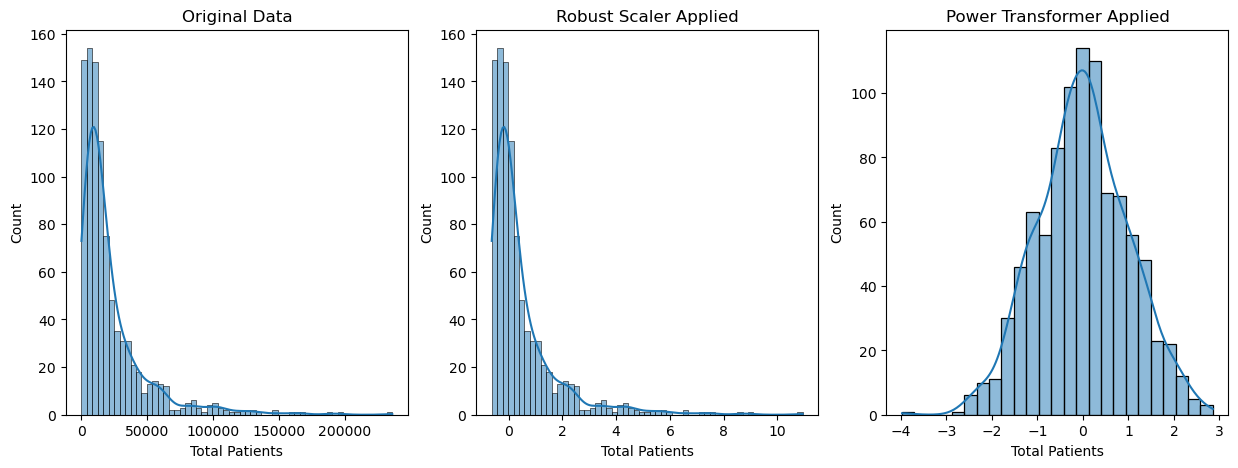

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(X_train['total_patients'], ax=ax[0], kde=True)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Total Patients')

sns.histplot(X_train_reduced_robust['total_patients'], ax=ax[1], kde=True)
ax[1].set_title('Robust Scaler Applied')
ax[1].set_xlabel('Total Patients')

sns.histplot(X_train_reduced_power['total_patients'], ax=ax[2], kde=True)
ax[2].set_title('Power Transformer Applied')
ax[2].set_xlabel('Total Patients')
plt.show()

## Rounding target variable

In [587]:
y_train_rounded = y_train.round(-5)
y_test_rounded = y_test.round(-5)

In [590]:
y_train_rounded.head()

,total_hc_funding
1182,2000000
588,3900000
459,3000000
1197,2900000
1176,800000


In [591]:
print(y_train.shape, y_train_rounded.shape)

(939, 1) (939, 1)


In [592]:
print(y_test.shape, y_test_rounded.shape)

(403, 1) (403, 1)


## Saving files

In [593]:
# Set 1: Reduced datasets scaled with RobustScaler
dict_reduced_robust = {
    'X_train_reduced_robust': X_train_reduced_robust,
    'X_test_reduced_robust': X_test_reduced_robust,
    'y_train_data': y_train,
    'y_test_data': y_test
}

# Set 2: Imputed datasets scaled with RobustScaler
dict_imputed_robust = {
    'X_train_imputed_robust': X_train_imputed_robust,
    'X_test_imputed_robust': X_test_imputed_robust,
    'y_train_data': y_train,
    'y_test_data': y_test
}

# Set 3: Reduced datasets scaled with PowerTransformer
dict_reduced_power= {
    'X_train_reduced_power': X_train_reduced_power,
    'X_test_reduced_power': X_test_reduced_power,
    'y_train_data': y_train,
    'y_test_data': y_test
}

# Set 4: Imputed datasets scaled with PowerTransformer
dict_imputed_power= {
    'X_train_imputed_power': X_train_imputed_power,
    'X_test_imputed_power': X_test_imputed_power,
    'y_train_data': y_train,
    'y_test_data': y_test
}


In [594]:
def save_files(data_dict, columns, data_path):
    """
    Saves training and testing data to CSV files in the specified directory using names derived from the data dictionary keys.
    
    Parameters:
    - data_dict: Dictionary with keys as intended file names and values as the data (Numpy array or DataFrame).
    - columns: List of column names for the features, applicable if data values are Numpy arrays.
    - data_path: Path to the directory where files will be saved.
    """
    # Ensure the directory exists
    os.makedirs(data_path, exist_ok=True)
    
    # Iterate through the dictionary items
    for dataset_name, data in data_dict.items():
        # Determine if the data is a DataFrame or needs conversion
        if isinstance(data, pd.DataFrame):
            df = data
        else:
            df = pd.DataFrame(data, columns=columns)
        
        # Construct file path
        file_path = os.path.join(data_path, f'{dataset_name}.csv')
        
        # Save the DataFrame to a CSV file
        df.to_csv(file_path, index=False)
        print(f"File saved successfully: {file_path}")

In [595]:
y_train_rounded.to_csv(MODELING_PATH + 'y_train_rounded.csv', index=False)
y_test_rounded.to_csv(MODELING_PATH + 'y_test_rounded.csv', index=False)

In [596]:
save_files(dict_reduced_robust, X_train_reduced_robust.columns, MODELING_PATH)
save_files(dict_imputed_robust, X_train_imputed_robust.columns, MODELING_PATH)
save_files(dict_reduced_power, X_train_reduced_power.columns, MODELING_PATH)
save_files(dict_imputed_power, X_train_imputed_power.columns, MODELING_PATH)

File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/X_train_reduced_robust.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/X_test_reduced_robust.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/y_train_data.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/y_test_data.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/X_train_imputed_robust.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/X_test_imputed_robust.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-fqhc-model/data/modeling/train-test/y_train_data.csv
File saved successfully: /Users/katialopes-gilbert/repos/capstone-project-